In [1]:
import os
import sys
import pickle
import numpy as np
import scipy as sc
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, grad
import time
import numpy as np

In [3]:
batch_size = 64
epochs = 100
seed = 1
lr = 0.01
momentum = 0.5
log_interval = 10
PATH = "model" # model path
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=batch_size, shuffle=True)

In [5]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__() #load super class for training data
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU()

    def forward(self, x): #feed forward
        layer1 = x.view(-1, 784) # flatten
        layer2 = self.relu(self.fc1(layer1))
        return F.log_softmax(layer2, dim=1)

In [6]:
model = DNN()
if cuda:
    model.cuda()
print (model)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print (optimizer)

DNN(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
)


In [7]:
loss_history = []
miniratio_history = []
cnt = 0

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        grads = grad(loss, model.parameters(), create_graph=True)
        grad_norm = cal_norm_grad(grads)
        if grad_norm.cpu().data[0] == 0:
            miniratio_history.append(cal_miniratio(grads))
            loss_history.append(loss.data[0])
        
        grad_norm.backward()
        optimizer.step()
        
        '''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]), end='\r')
        '''

In [9]:
def cal_norm_grad(grad_params):
    grad_norm = 0
    for grad in grad_params:
        grad_norm += grad.pow(2).sum()
    grad_norm = grad_norm.sqrt()
    return grad_norm

In [10]:
def cal_miniratio(grads):
    flat_grad = torch.cat([g.view(-1) for g in grads])
    hessian = []
    for g in flat_grad:
        tmp = grad(g, model.parameters(), create_graph=True)
        flat_tmp = torch.cat([g.view(-1) for g in tmp]).data.cpu().numpy()
        hessian.append(tmp)
    eigval = np.linalg.eigvalsh(hessian)
    cnt = 0
    for i in eigval:
        if i > 0:
            cnt += 1
    return cnt/len(eigval)

In [11]:
for epoch in range(epochs):
    print ("Epoch", epoch, len(loss_history), end='\r')
    train(epoch)

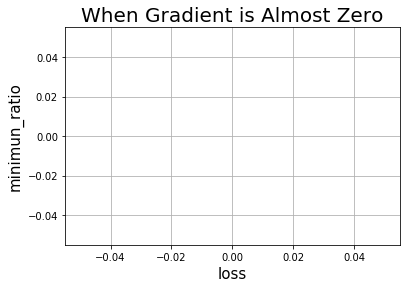

In [12]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_xlabel('loss', fontsize = 15)
ax.set_ylabel('minimun_ratio', fontsize = 15)
ax.set_title('When Gradient is Almost Zero', fontsize = 20)
ax.scatter(loss_history, miniratio_history)
ax.grid()
plt.savefig('WhenGradientisAlmostZero.png')